Notebook Author: **Arash Shahidi** (GSN-LMU)

Date Created: 2022  
Date Modified: 2025 (plots modified)  

---

This notebook is based on the Neuromatch project on the Stringer dataset:

- [Neuromatch Project README](https://compneuro.neuromatch.io/projects/neurons/README.html)
- [Colab: Load Stringer Orientations](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/projects/neurons/load_stringer_orientations.ipynb)

**YouTube:**  
- [Projects Dataset: Stringer 10,000+ neurons](https://www.youtube.com/watch?v=78GSgf6Dkkk)

---

**Cohomological extraction** is based on the code used in the Master's Thesis of Loek Van Rossem:

- [*"The Shape of Vision: Decoding the Primary Visual Cortex with Homology"*](https://www.theorie.physik.uni-muenchen.de/TMP/theses/index.html)
(advisor: Dr. Martin Stemmler)

# Decoding Orientation of Static Grating Stimuli from Mouse V1 Activity: 
Cohomological Feature Extraction

In [1]:
# @title imports
import numpy as np
import pandas as pd
import persim
import matplotlib.pyplot as plt
import math
from umap import UMAP
import ripser
from scipy.optimize import least_squares
from tqdm import trange
from scipy.stats import zscore, rankdata

In [2]:
import random
import numpy as np

SEED = 42

# Python built-in random
random.seed(SEED)

# NumPy
np.random.seed(SEED)

## Load Data

In [3]:
file = '../data/stringer_orientations_pca.npy'
data = np.load(file, allow_pickle=True).item()
X, stim, run = data['pc_score'], data['orientation'], data['run']
print('X.shape', X.shape)
print('stim.shape', stim.shape)
print('run.shape', run.shape)

X.shape (4598, 200)
stim.shape (4598,)
run.shape (4598,)


4598 trials. In each trial, a static orientation grating was shown to the mouse.

data has fields:
* `data['pc_score']`: (4598, 200) contains the population activity score along the first 200 principal components - PCA was carried out on the population activity of ~23000 neurons

* `data['istim']`: (4598,) contains orientation values shown on each trial, orientation values range from 0 to 2*np.pi.

For more details see https://compneuro.neuromatch.io/projects/neurons/README.html#stringer

(#samples, #features) = dat['sresp'] (4598, 23589) ----PCA---> (4598, 200)

## Dimensionality Reduction
### Principal components

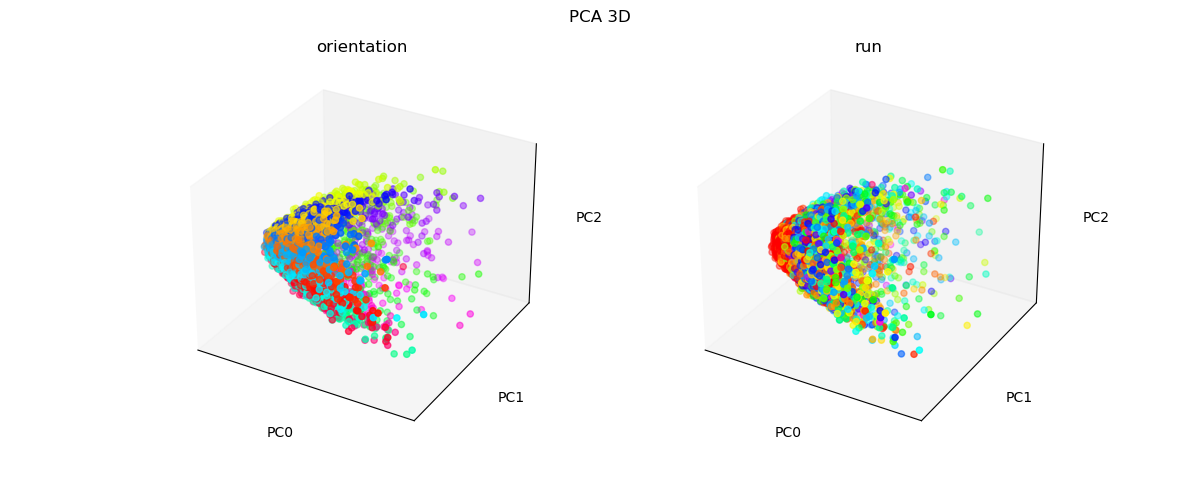

In [4]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%matplotlib widget

x, y, z = X[:,0], X[:,1], X[:,2]

fig = plt.figure(figsize=(12, 5))
ax0 = fig.add_subplot(1, 2, 1, projection='3d')
ax0.scatter3D(x, y, z, c=stim, cmap='hsv')
ax0.set(xlabel="PC0", ylabel="PC1", zlabel="PC2", xticks=[], yticks=[], zticks=[], 
title='orientation')

ax1 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.scatter3D(x, y, z, c=run, cmap='hsv')
ax1.set(xlabel="PC0", ylabel="PC1", zlabel="PC2", xticks=[], yticks=[], zticks=[], 
title='run')

fig.suptitle('PCA 3D')
plt.show()

In [5]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Coordinates
x, y, z = X[:, 0], X[:, 1], X[:, 2]

# Create 1-row, 2-column 3D subplot
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    subplot_titles=("color: orientation", "color: run")
)

# First subplot: orientation
fig.add_trace(
    go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(color=stim, colorscale='HSV', size=2)
    ),
    row=1, col=1
)

# Second subplot: run
fig.add_trace(
    go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(color=run, colorscale='HSV', size=2)
    ),
    row=1, col=2
)

# Set layout to increase plot size and spacing
zoomx = -1.8 # Adjust zoom level for better visibility
zoomy = -1.8
zoomz = 1.8
fig.update_layout(
    title='PCA 3D: HTML Interactive (Note the Paraboloid Shape)',
    height=800,
    width=1200,
    margin=dict(l=100, r=0, t=200, b=0),
    
    title_font=dict(size=24),  # Like talk/presentation context

    scene=dict(
        xaxis_title='PC0',
        yaxis_title='PC1',
        zaxis_title='PC2',
        xaxis=dict(title_font=dict(size=18), tickfont=dict(size=14)),
        yaxis=dict(title_font=dict(size=18), tickfont=dict(size=14)),
        zaxis=dict(title_font=dict(size=18), tickfont=dict(size=14)),
    ),
    scene_camera=dict(
        eye=dict(x=zoomx, y=zoomy, z=zoomz)  # Adjusted zoom level 
    ),
    scene2=dict(
        xaxis_title='PC0',
        yaxis_title='PC1',
        zaxis_title='PC2',
        xaxis=dict(title_font=dict(size=18), tickfont=dict(size=14)),
        yaxis=dict(title_font=dict(size=18), tickfont=dict(size=14)),
        zaxis=dict(title_font=dict(size=18), tickfont=dict(size=14)),
    ),
    scene2_camera=dict(
        eye=dict(x=zoomx, y=zoomy, z=zoomz)  # Adjusted zoom level 
    ),
    showlegend=False
)

# Style subplot titles
for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=32, family='Arial', color='black')
fig.show()

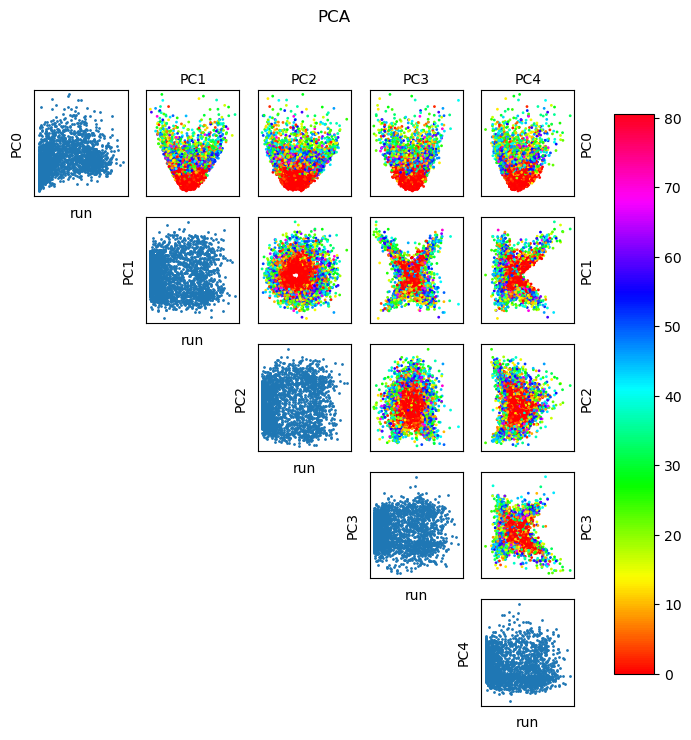

In [6]:
%matplotlib inline

vmin_kwargs = lambda a: dict((zip(['vmin', 'vmax'], np.quantile(a, [0, 1]))))
vm = vmin_kwargs(run)
ncomp_disp = 5
fig = plt.figure(figsize=(8,8))
for j in range(ncomp_disp):
  for i in range(j+1):
    ax = fig.add_subplot(ncomp_disp,ncomp_disp, j + ncomp_disp*i + 1)
    if i == j:
      ax.scatter(run, X[:, i], s=1)
      ax.set(xlabel='run', ylabel='PC%d'%i)
    else:
      im = ax.scatter(X[:, j], X[:, i], s=1, c=run, cmap='hsv', **vm)
    
    ax.set(xticks=[], yticks=[])
    
    if i==0 and j>0:
      ax.set(xlabel='PC%d'%j)
      ax.xaxis.set_label_position('top') 
      ax.phase_spectrum
    if j==ncomp_disp-1 and i<ncomp_disp-1:
      ax.set(ylabel='PC%d'%i)
      ax.yaxis.set_label_position('right') 

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.set_facecolor('white')
fig.suptitle('PCA')
plt.show()

### UMAP

In [7]:
ncomp = 10 
xinit = 3 * zscore(X[:, :ncomp], axis=0)
embed = UMAP(n_components=ncomp, init=xinit, n_neighbors=25,
             metric='euclidean').fit_transform(X) # , random_state=42

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


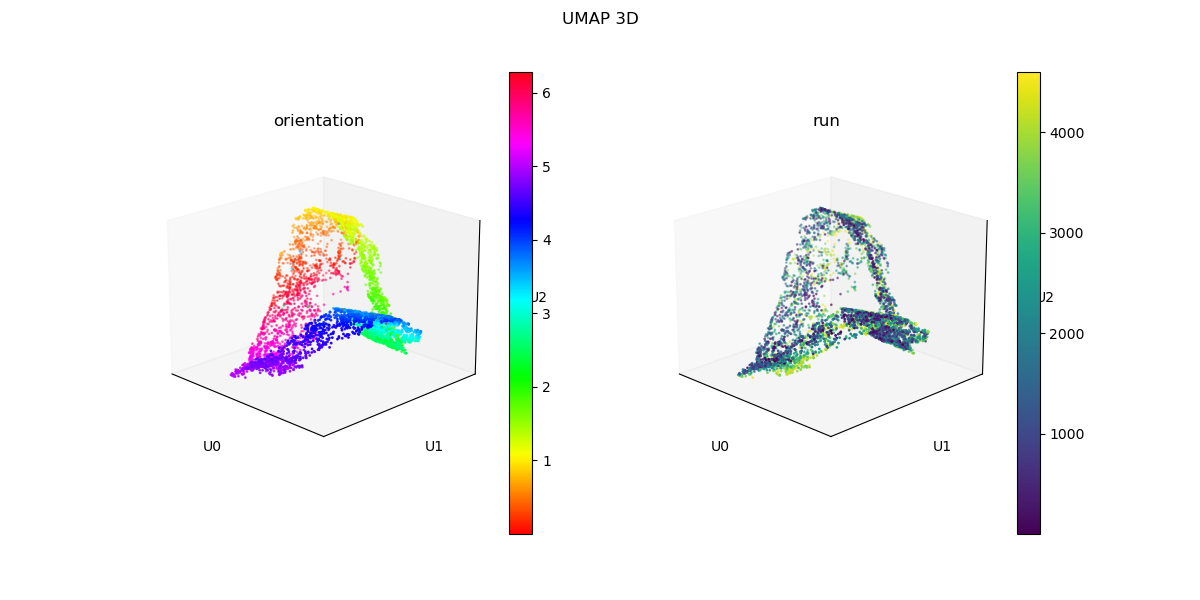

In [8]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%matplotlib widget

x, y, z = embed[:,0], embed[:,1], embed[:,2]
elev = 20
azim = 135

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
im = ax.scatter3D(x, y, z, s=1, c=stim, cmap='hsv', **vmin_kwargs(stim))
ax.set(xlabel="U0", ylabel="U1", zlabel="U2", xticks=[], yticks=[], zticks=[])
ax.set_title('orientation')
ax.view_init(elev=elev, azim=azim)

fig.colorbar(im)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
im2 = ax2.scatter3D(x, y, z, s=1, c=rankdata(run, 'ordinal'), cmap='viridis', **vmin_kwargs(rankdata(run, 'ordinal')))
ax2.set(xlabel="U0", ylabel="U1", zlabel="U2", xticks=[], yticks=[], zticks=[])
ax2.set_title('run')
ax2.view_init(elev=elev, azim=azim)

fig.suptitle('UMAP 3D')
cbar = fig.colorbar(im2)

plt.show()

In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import rankdata

# Data
x, y, z = embed[:, 0], embed[:, 1], embed[:, 2]
ranked_run = rankdata(run, method='ordinal')

# Create subplots
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    subplot_titles=("color: orientation", "color: run")
)

# Orientation subplot (left)
fig.add_trace(
    go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(
            size=2,
            color=stim,
            colorscale='HSV',
            colorbar=dict(
                title='stim',
                x=0.44  # ⬅️ Push colorbar just left of center
            ),
            showscale=True
        ),
        name='orientation'
    ),
    row=1, col=1
)

# Run subplot (right)
fig.add_trace(
    go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(
            size=2,
            color=ranked_run,
            colorscale='Viridis',
            colorbar=dict(
                title='run (ranked)',
                x=1.0  # ⬅️ Keep colorbar fully to the right
            ),
            showscale=True
        ),
        name='run'
    ),
    row=1, col=2
)

eyedict = dict(x=-1.5, y=1.5, z=0.7)  # azim ≈ 135°, elev ≈ 20°
# Layout settings
fig.update_layout(
    title='UMAP 3D',
    height=600,
    width=1400,
    margin=dict(l=100, r=100, t=60, b=0),
    scene=dict(
        xaxis_title='U0', yaxis_title='U1', zaxis_title='U2',
        xaxis=dict(showticklabels=False),
        yaxis=dict(showticklabels=False),
        zaxis=dict(showticklabels=False)
    ),
    scene_camera=dict(
        eye=eyedict
    ),
    scene2=dict(
        xaxis_title='U0', yaxis_title='U1', zaxis_title='U2',
        xaxis=dict(showticklabels=False),
        yaxis=dict(showticklabels=False),
        zaxis=dict(showticklabels=False)
    ),
    scene2_camera=dict(
        eye=eyedict
    ),
    showlegend=False
)

# Style subplot titles
for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=32, family='Arial', color='black')

fig.show()

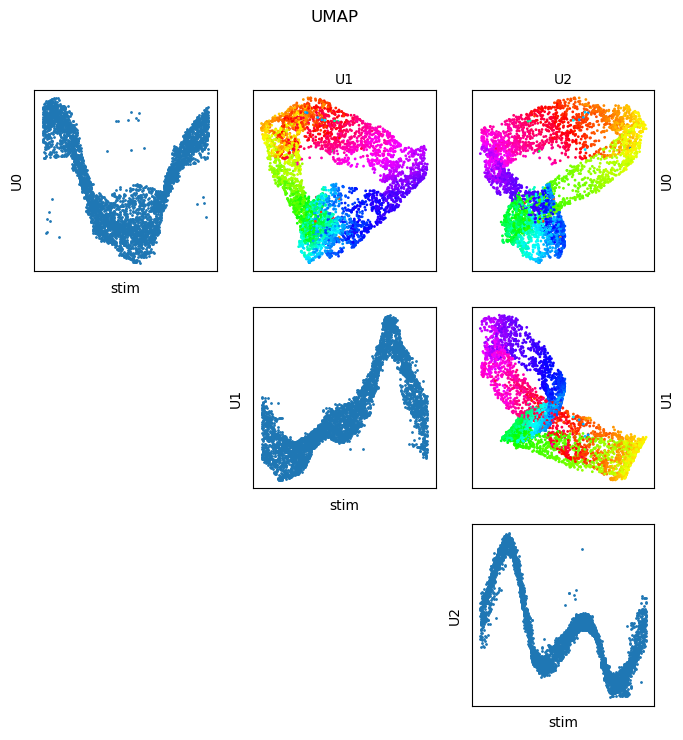

In [10]:
%matplotlib inline
ncomp_disp = 3
fig = plt.figure(figsize=(8,8))
for j in range(ncomp_disp):
  for i in range(j+1):
    ax = fig.add_subplot(ncomp_disp,ncomp_disp, j + ncomp_disp*i + 1)
    if i == j:
      ax.scatter(stim, embed[:, i], s=1)
      ax.set(xlabel='stim', ylabel='U%d'%i)
    else:
      ax.scatter(embed[:, j], embed[:, i], s=1, c=stim, cmap='hsv')
    
    ax.set(xticks=[], yticks=[])
    
    if i==0 and j>0:
      ax.set(xlabel='U%d'%j)
      ax.xaxis.set_label_position('top')

    if j==ncomp_disp-1 and i<ncomp_disp-1:
      ax.set(ylabel='U%d'%i)
      ax.yaxis.set_label_position('right')

fig.set_facecolor('white')
fig.suptitle('UMAP')

plt.show()

## Point cloud simplification
### Radial distance

For faster computation we need to reduce the number of datapoints

In [11]:
def radial_distance(X, eps, random_state=None):
    """
    point cloud simplification using radial distance (euclidean metric). 
    Start with the first point in in X and mark it as a key point. All consecutive points that have a distance less than a predetermined distance eps to the key point are removed. The first point that have a distance greater than eps to the key point is marked as the new key point. The process repeates itself from this new key point, and continues until it reaches the end of the point cloud.
    
    Parameters
    ----------
    X: pandas DataFrame (n_datapoints, n_features):

    eps: max radial distance - cutoff distance

    random_state: seed of random generator used for choosing the inital point

    Returns
    -------
    X_reduced: chosen data points 

    indices: indices of the chosen data points
    """
    if random_state is not None:
        np.random.seed(random_state)
        
    ix0 = np.random.choice(X.shape[0])
    x0 = X.iloc[ix0]
    xt = x0
    ixt = ix0
    X_temp = X
    ind_reduced = [ix0]

    while True:
        dist = np.linalg.norm(X_temp.to_numpy() - xt.to_numpy(), axis=1)
        cond = dist < eps

        X_temp = X_temp.drop(X_temp.index[np.where(cond)])
        if len(X_temp)==0:
            break

        where_not_cond = np.where(np.logical_not(cond))
        w = np.argmin(dist[where_not_cond])        
        ixt = X_temp.index[w]
        xt = X.iloc[ixt]
        ind_reduced.append(ixt)

    return X.iloc[ind_reduced]


In [12]:
eps = 0.6
embed_reduced = radial_distance(pd.DataFrame(embed), eps=eps) # , random_state=42
stim_r = stim[embed_reduced.index]
run_r = run[embed_reduced.index]
embed_r = embed_reduced.to_numpy()

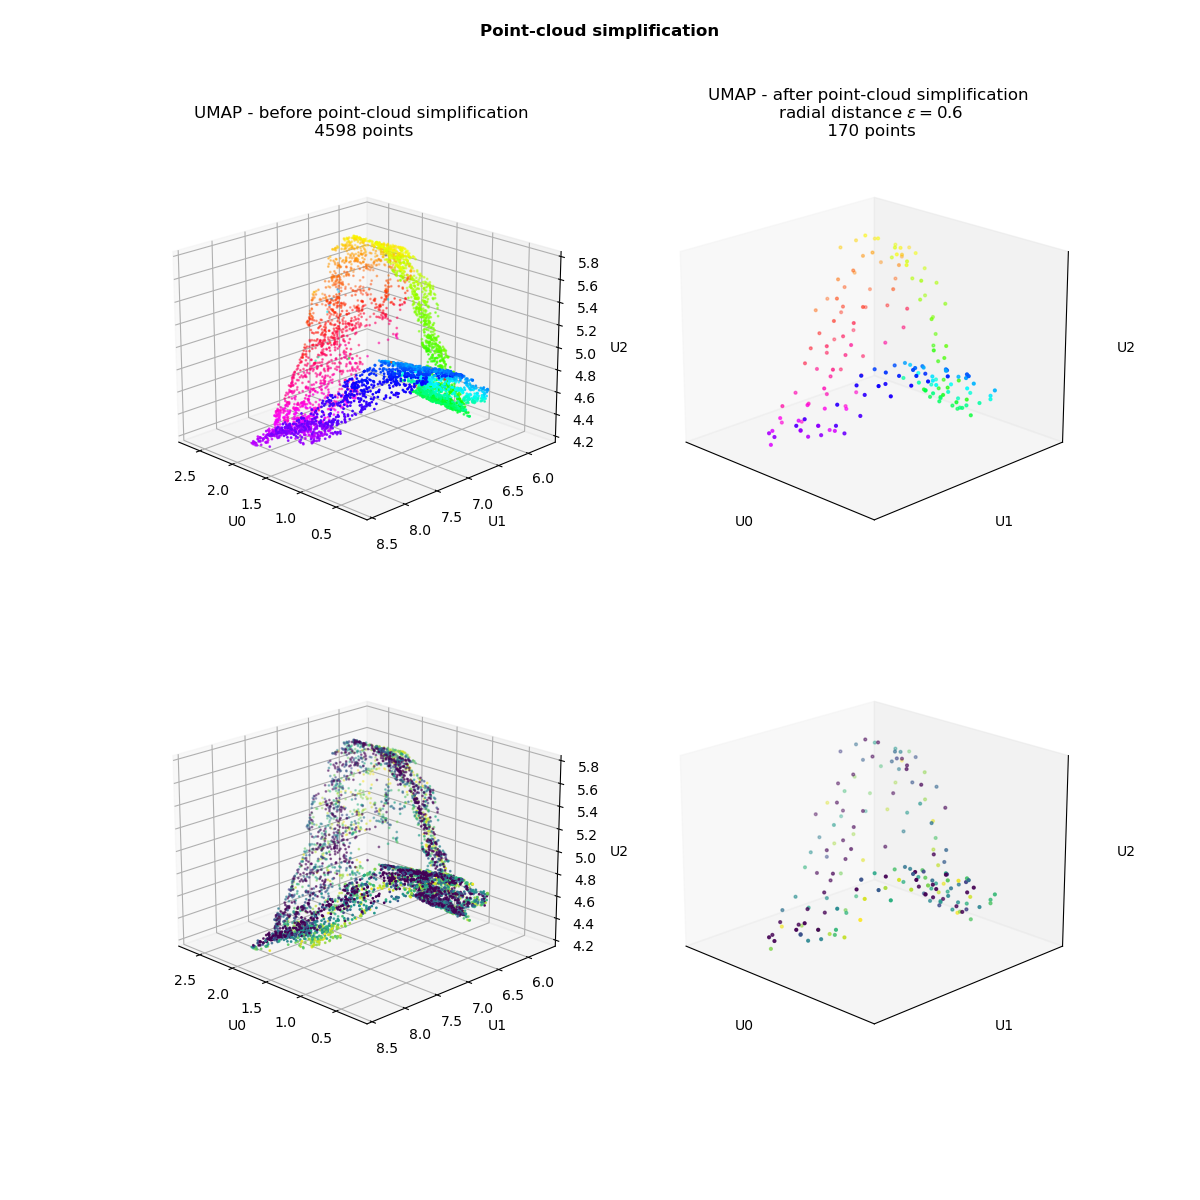

In [13]:
%matplotlib widget

x, y, z = embed[:,0], embed[:,1], embed[:,2]

fig = plt.figure(figsize=(12, 12))

# View settings
elev = 20   # vertical angle (degrees)
azim = 135  # horizontal angle (degrees)

ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax1.scatter3D(x, y, z, c=stim, cmap='hsv', s=1)
ax1.set(xlabel="U0", ylabel="U1", zlabel="U2",
        title='UMAP - before point-cloud simplification\n %d points' % embed.shape[0])
ax1.view_init(elev=elev, azim=azim)

x_r, y_r, z_r = embed_r[:,0], embed_r[:,1], embed_r[:,2]

ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax2.scatter3D(x_r, y_r, z_r, c=stim_r, cmap='hsv', s=4)
ax2.set(xlabel="U0", ylabel="U1", zlabel="U2", xticks=[], yticks=[], zticks=[],
        title='UMAP - after point-cloud simplification\n radial distance $\epsilon=%.1f$\n %d points' % (eps, embed_r.shape[0]))
ax2.view_init(elev=elev, azim=azim)

ax3 = fig.add_subplot(2, 2, 3, projection='3d')
ax3.scatter3D(x, y, z, c=rankdata(run), cmap='viridis', s=1)
ax3.set(xlabel="U0", ylabel="U1", zlabel="U2")
ax3.view_init(elev=elev, azim=azim)

ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ax4.scatter3D(x_r, y_r, z_r, c=rankdata(run_r), cmap='viridis', s=4)
ax4.set(xlabel="U0", ylabel="U1", zlabel="U2", xticks=[], yticks=[], zticks=[])
ax4.view_init(elev=elev, azim=azim)

fig.suptitle('Point-cloud simplification', weight='bold')
plt.show()


## Cohomological feature extraction
### persistent homology


In [14]:
ripser_result = ripser.ripser(embed_r, maxdim=1, coeff=23, do_cocycles=False)

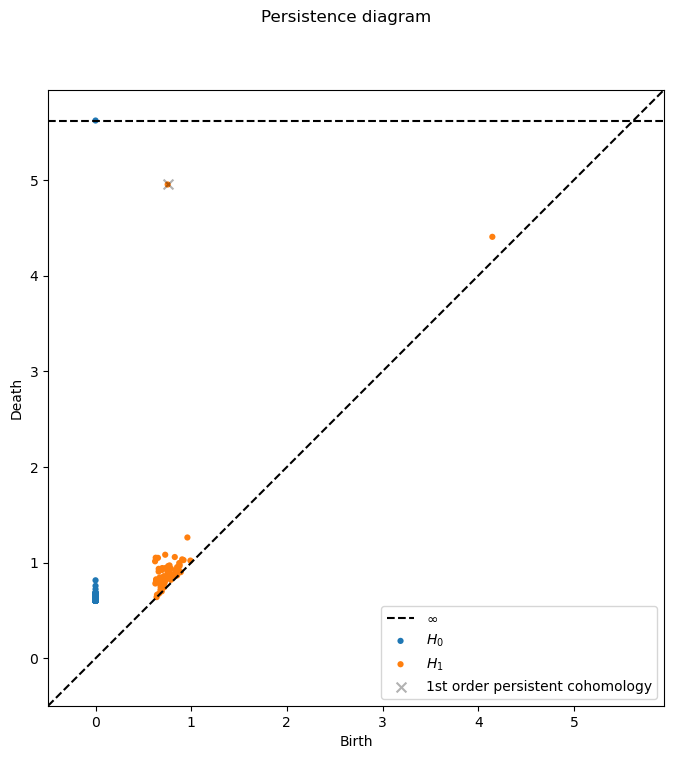

In [15]:
%matplotlib inline
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
persim.plot_diagrams(ripser_result['dgms'], ax=ax)
dgm1 = ripser_result['dgms'][1]
idx = np.argmax(dgm1[:, 1] - dgm1[:, 0])
ax.scatter(dgm1[idx, 0], dgm1[idx, 1], 50, 'k', 'x', label='1st order persistent cohomology', alpha=0.3)
ax.legend()
fig.suptitle('Persistence diagram')
plt.show()

For simple example of persistent homology and representative cocycles see https://ripser.scikit-tda.org/en/latest/notebooks/Representative%20Cocycles.html#:~:text=Ripser%20is%20cohomology%20based%2C%20and,from%20the%20persistent%20cohomology%20algorithm.

### circular parametrization

In [16]:
# cohomological parametrization

EPSILON = 0.0000000000001

def shortest_cycle(graph, node2, node1):
    """
    Returns the shortest cycle going through an edge
    
    Used for computing weights in decode
    
    Parameters
    ----------
    graph: ndarray (n_nodes, n_nodes)
        A matrix containing the weights of the edges in the graph
    node1: int
        The index of the first node of the edge
    node2: int
        The index of the second node of the edge

    Returns
    -------
    cycle: list of ints
        A list of indices representing the nodes of the cycle in order
    """
    N = graph.shape[0]
    distances = np.inf * np.ones(N)
    distances[node2] = 0
    prev_nodes = np.zeros(N)
    prev_nodes[:] = np.nan
    prev_nodes[node2] = node1
    while (math.isnan(prev_nodes[node1])):
        distances_buffer = distances
        for j in range(N):
            possible_path_lengths = distances_buffer + graph[:,j]
            if (np.min(possible_path_lengths) < distances[j]):
                prev_nodes[j] = np.argmin(possible_path_lengths)
                distances[j] = np.min(possible_path_lengths)
    prev_nodes = prev_nodes.astype(int)
    cycle = [node1]
    while (cycle[0] != node2):
        cycle.insert(0,prev_nodes[cycle[0]])
    cycle.insert(0,node1)
    return cycle


def cohomological_parameterization(X ,cocycle_number=1, coeff=2,weighted=False):
    """
    Compute an angular parametrization on the data set corresponding to a given
    1-cycle
    
    Parameters
    ----------
    X: ndarray(n_datapoints, n_features):
        Array containing the data
    cocycle_number: int, optional, default 1
        An integer specifying the 1-cycle used
        The n-th most stable 1-cycle is used, where n = cocycle_number
    coeff: int prime, optional, default 1
        The coefficient basis in which we compute the cohomology
    weighted: bool, optional, default False
        When true use a weighted graph for smoother parameterization
        as proposed in arxiv:1711.07205
    
    Returns
    -------
    decoding: ndarray(n_datapoints)
        The parameterization of the dataset consisting of a number between
        0 and 1 for each datapoint, to be interpreted modulo 1
    """
    # Get the cocycle
    result = ripser.ripser(X, maxdim=1, coeff=coeff, do_cocycles=True)
    diagrams = result['dgms']
    cocycles = result['cocycles']
    D = result['dperm2all']
    dgm1 = diagrams[1]
    idx = np.argsort(dgm1[:, 1] - dgm1[:, 0])[-cocycle_number] 
    cocycle = cocycles[1][idx]
    thresh = dgm1[idx, 1]-EPSILON
    
    # Compute connectivity
    N = X.shape[0]
    connectivity = np.zeros([N,N])
    for i in range(N):
        for j in range(i):
            if D[i, j] <= thresh:
                connectivity[i,j] = 1
    cocycle_array = np.zeros([N,N])
    
    # Lift cocycle
    for i in range(cocycle.shape[0]):
        cocycle_array[cocycle[i,0],cocycle[i,1]] = (
            ((cocycle[i,2] + coeff/2) % coeff) - coeff/2
            )
        
    # Weights
    if (weighted):
        def real_cocycle(x):
            real_cocycle =(
                connectivity * (cocycle_array + np.subtract.outer(x, x))
                )
            return np.ravel(real_cocycle)
        
        # Compute graph
        x0 = np.zeros(N)
        res = least_squares(real_cocycle, x0)
        real_cocyle_array = res.fun
        real_cocyle_array = real_cocyle_array.reshape(N,N)
        real_cocyle_array = real_cocyle_array - np.transpose(real_cocyle_array)
        graph = np.array(real_cocyle_array>0).astype(float)
        graph[graph==0] = np.inf
        graph = (D + EPSILON) * graph   # Add epsilon to avoid NaNs
        
        # Compute weights
        cycle_counts = np.zeros([N,N])  
        iterator = trange(0, N, position=0, leave=True)
        iterator.set_description("Computing weights for decoding")
        for i in iterator:
            for j in range(N):
                if (graph[i,j] != np.inf):
                    cycle = shortest_cycle(graph, j, i)
                    for k in range(len(cycle)-1):
                        cycle_counts[cycle[k], cycle[k+1]] += 1
                
        weights = cycle_counts / (D + EPSILON)**2
        weights = np.sqrt(weights)
    else:
        weights = np.outer(np.ones(N),np.ones(N))
        
    def real_cocycle(x):
        real_cocycle =(
            weights * connectivity * (cocycle_array + np.subtract.outer(x, x))
            )
        return np.ravel(real_cocycle)
    
    # Smooth cocycle
    print("Decoding...", end=" ")
    x0 = np.zeros(N)
    res = least_squares(real_cocycle, x0)
    decoding = res.x
    decoding = np.mod(decoding, 1)
    print("done")
    
    decoding = pd.DataFrame(decoding, columns=["decoding"])
    decoding = decoding.set_index(X.index)
    return decoding


In [17]:
decoding = cohomological_parameterization(pd.DataFrame(embed_r), cocycle_number=1, coeff=23, weighted=False)

Decoding... done


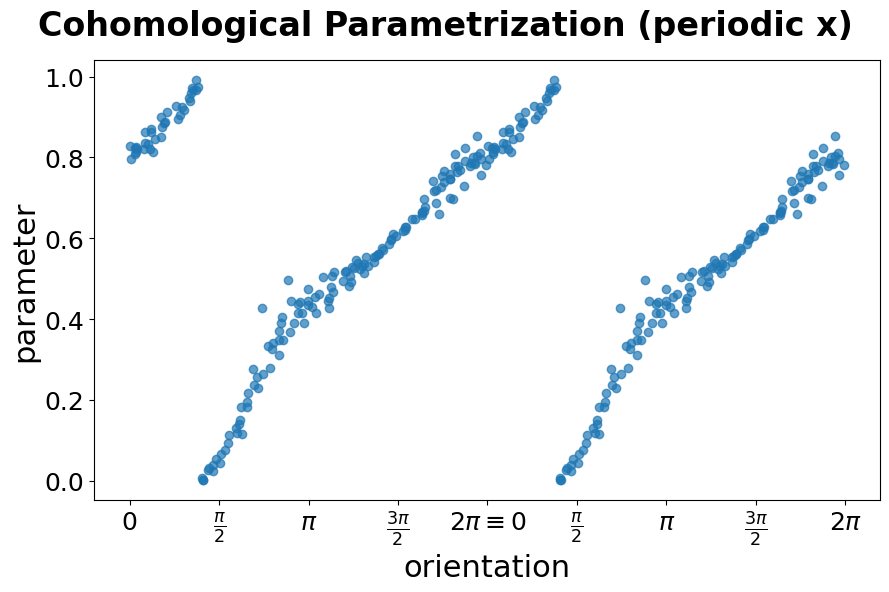

In [18]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

# Repeat x and y for periodicity demonstration
x = stim_r
y = decoding['decoding'].to_numpy()
ax.scatter(np.concatenate([x, x + 2 * np.pi]), np.concatenate([y, y]), alpha=0.7)

ax.tick_params(axis='both', labelsize=18)
ax.set_xlabel('orientation', fontsize=22)
ax.set_ylabel('parameter', fontsize=22)

# Custom x-ticks: 0, pi/2, pi, 3pi/2, 2pi/0, pi/2+2pi, pi+2pi, 3pi/2+2pi, 2pi+2pi
xticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi, 2*np.pi + np.pi/2, 2*np.pi + np.pi, 2*np.pi + 3*np.pi/2, 4*np.pi]
xticklabels = [
    r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$",
    r"$2\pi\equiv0$",  # Special label in the middle
    r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$",
    r"$2\pi$"
]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

fig.suptitle('Cohomological Parametrization (periodic x)', weight='bold', fontsize=24)

plt.tight_layout()
plt.show()

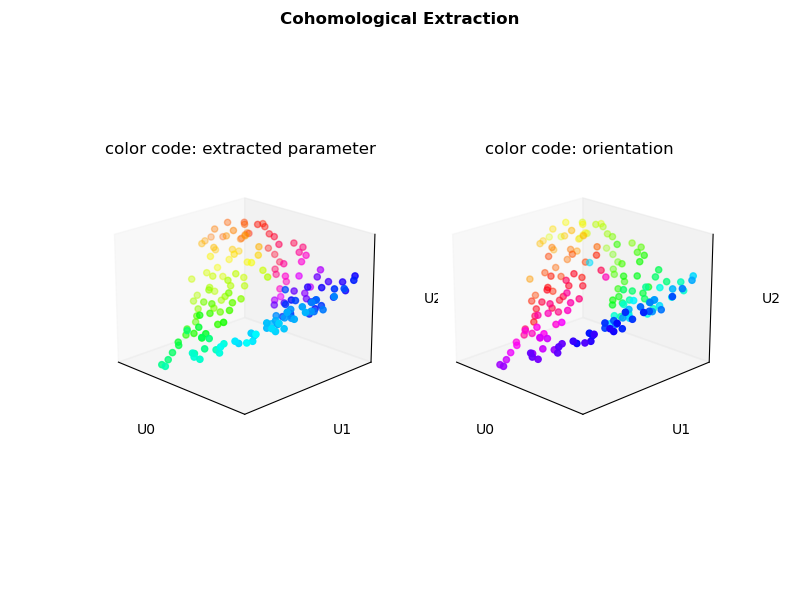

In [80]:
%matplotlib inline
%matplotlib widget

elev = 20   # vertical angle (degrees)
azim = 135  # horizontal angle (degrees)
fig = plt.figure(figsize=(8, 6))

x_r, y_r, z_r = embed_r[:,0], embed_r[:,1], embed_r[:,2]

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.scatter3D(x_r, y_r, z_r, c=decoding['decoding'], cmap='hsv')
ax1.set(xlabel="U0", ylabel="U1", zlabel="U2", xticks=[], yticks=[], zticks=[], title='color code: extracted parameter')
ax1.view_init(elev=elev, azim=azim)

x_r, y_r, z_r = embed_r[:,0], embed_r[:,1], embed_r[:,2]

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter3D(x_r, y_r, z_r, c=stim_r, cmap='hsv')
ax2.set(xlabel="U0", ylabel="U1", zlabel="U2", xticks=[], yticks=[], zticks=[], title='color code: orientation')
ax2.view_init(elev=elev, azim=azim)

plt.suptitle('Cohomological Extraction', weight='bold')
plt.show()